# IAM 961 HW4: QR decomp

Due Wednesday Oct 28, 2020. Some basic Julia syntax tips are provided at the end of this notebook.

## Problem 1.
Write the following Julia functions for computing the QR decomposition of a matrix
  + `qrcgs(A)` via Classical Gram-Schmidt orthogonalization,
  + `qrmgs(A)` via Modified Gram-Schmidt orthogonalization, and
  + `qrhouse(A)` via Householder triangularization.
  
Each function should return the two matrices Q and R. If you want you can assume A is square.

In [1]:
using LinearAlgebra

m = 50
A = randn(m,m)

function qrcgs(A)
    # Assuming A is a square matrix
    m = size(A)[1]
    Q = zeros(m,m)
    R = zeros(m,m)

    for i in 1:m
        v = A[:,i]
        for j = 1:i-1
            R[j,i] = dot(Q[:,j], A[:,i])
            v = v - R[j,i]*Q[:,j]
        end
        R[i,i] = norm(v)
        Q[:,i] = v/norm(v)
    end
    
    return Q, R
end

function qrmgs(A)
    Q = zeros(m,m)
    R = zeros(m,m)

    for i in 1:m
        v = A[:,i]
        for j = 1:i-1
            R[j,i] = dot(Q[:,j], v)
            v = v - R[j,i]*Q[:,j]
        end
        R[i,i] = norm(v)
        Q[:,i] = v/norm(v)
    end
    
    return Q, R
end

function qrhouse(A)
    Q = 1.0*Matrix(I,m,m)
    R = deepcopy(A)
    
    for i in 1:m-1
        #create the unit vector along which reflection is desired
        e = zeros(m-i+1)
        e[1] = 1.0

        #create the projection matrix about plane perpendicular to v
        #this reflects the ith column of A and gives the ith column of Q 
        v = R[i:end,i] + sign(R[i,i])*norm(R[i:end,i])*e
        v = v/norm(v)
        F = I - 2*v*v'

        #create Qi = Qi-1 * ... Q3 * Q2 * Q1
        #it has the form Q = [I 0;0 F]
        Q1 = 1.0*Matrix(I, m, m)
        Q1[i:end,i:end] = F[1:end,1:end]
        Q = Q1*Q

        #create R
        R[i:end,i:end] = F*R[i:end,i:end]
    end
    Q = Q';
    return Q, R
end  

qrhouse (generic function with 1 method)

## Problem 2.
Test that your QR algorithms work correctly on a fairly small and well-conditioned matrix (e.g. a 5 x 5 matrix with normally distributed elements, `A = randn(5,5)`).  You should test that $Q$ is unitary and that $QR \approx A$. Verify to your own satisfaction that $R$ is upper-triangular. Make these tests as compact and readable as you can!

In [2]:
(Q1,R1) = qrcgs(A);
(Q2,R2) = qrmgs(A);
(Q3,R3) = qrhouse(A);

#Check for CGS
testC1 = Q1*R1 - A; #QR = A ?
testC2 = Q1[:,1]'*Q1[:,2:end] #Q is unitary ?
testC3 = R1 - UpperTriangular(R1) #R is upper triangular ?

#Check for MGS
testM1 = Q2*R2 - A;
testM2 = Q2[:,1]'*Q2[:,2:end]
testM3 = R2 - UpperTriangular(R2)

#Checks for Householder
testH1 = Q3*R3 - A;
testH2 = Q3[:,1]'*Q3[:,2:end]
testH3 = R3 - UpperTriangular(R3)

tol = 10^(-13)
if norm(testC1) > tol
    print("Error! CGS algorithm did not yield QR = A\n")
elseif norm(testC3) > tol
    print("Error! CGS algorithm did not yield a unitary Q")
elseif norm(testC3) > tol
    print("Error! CGS algorithm did not yield an upper triangular R\n")
    else 
    print("CGS works \n")
end

if norm(testM1) > tol
    print("Error! MGS algorithm did not yield QR = A\n")
elseif norm(testM2) > tol
    print("Error! MGS algorithm did not yield a unitary Q")
elseif norm(testM3) > tol
    print("Error! MGS algorithm did not yield an upper triangular R\n")
    else 
    print("MGS works \n")
end

if norm(testH1) > tol
    print("Error! Householder algorithm did not yield QR = A \n")
elseif norm(testH2) > tol
    print("Error! Householder algorithm did not yield a unitary Q")
elseif norm(testH3) > tol
    print("Error! Householder algorithm did not yield an upper triangular R\n")
    else 
    print("Householder works \n")
end

CGS works 
MGS works 
Householder works 


## Problem 3. 
Write a `backsub(R,b)` function that returns the solution $x$ of the upper-triangular system $Rx=b$ by backsubstitution. You can assume that $R$ is square and nonsingular. Test your backsubstitution function by solving an $Ax=b$ problem with your 5 x 5 $A$ matrix, one of your QR algorithms, and a known solution $x$. 


In [3]:
function backsub(A, b)
    A = UpperTriangular(A)
    x = zeros(m)
    for i in m:-1:1
        temp = 0
        for j in i+1:m
            temp = temp + A[i,j]*x[j]
        end
        x[i] = (b[i] - temp)/A[i,i]
    end
    return x
end

backsub (generic function with 1 method)

\begin{align}
Ax &= b\\
\Rightarrow QRx &= b\\
\Rightarrow Rx &= Q^T b
\end{align}

In [4]:
# backsub() check-1: against an unknown solution

m = 50
A = randn(m, m)
b = randn(m)
(Q, R) = qrhouse(A)
x = backsub(R, Q'*b)
if norm(R*x - Q'*b) > tol
    print("Error! backsub() is not working correctly")
else
    print("backsub() works")
end

backsub() works

In [5]:
# backsub check-2: against a known solution

m = 30
x = ones(m)
y = zeros(m)
A = randn(m, m)
b = A*x
(Q, R) = qrhouse(A)
b = Q'*b
# check for backsub
if norm(x - backsub(R,b)) > tol
    print("Error! backsub() is not working correctly")
else
    print("backsub() works")
end

backsub() works

## Problem 4. 
Write a function `A = randommatrix(m,n kappa)` function that returns an m x n
random matrix with condition number kappa and exponentially graded singular values
(i.e. $\sigma_1/\sigma_m = \kappa$ and $\sigma_{j+1}/\sigma_{j} = \text{const}$). 
You can use the Matlab code at the top of pg 65 in Trefethen and Bau as a starting 
point. Test that it works by constructing a 4 x 4 matrix with kappa=10^8 and then 
computing its condition number. 

In [6]:
function randommatrix(m, kappa)
    S = zeros(m, m)
    (U,X) = qrhouse(randn(m,m))
    (V,X) = qrhouse(randn(m,m))
    for i in 1:m
        S[i,i] = kappa^(1 - ((i-1)/(m-1)))
    end
    return U*S*V'
end

randommatrix (generic function with 1 method)

In [7]:
# check that randommatrix works i.e. yields a matrix with correct condition number
m = 4;
kappa = 10^8;
U = zeros(m,m);
S = zeros(m,m);
V = zeros(m,m);
A = randommatrix(m, kappa);
(U1,S1,V1) = svd(A)
kappa1 = S1[1]/S1[m]

9.999999960638475e7

## Problem 5.
Solve a large number of random $Ax=b$ problems using your QR decompositions
and `randommatrix` and `backsubstitution` functions, and produce a scatter 
plot of the normalized solution error  $\|\hat{x}-x\|/\|x\|$ versus $\kappa$. 
Plot data points from CGS in blue, MGS in red, and Householder in green.

Specifically: Construct a random $A$ matrix with $\kappa = 10^n$ where $n$ is 
a random real-valued number uniformly distributed between 0 and 18. 
Select a random $x$ vector with `x = randn(m,1)`, and then set $b = Ax$. For each of
the CGS, MGS, and Householder QR algorithms, compute the numerical solution $\hat{x}$ 
of $Ax=b$ via QR and then plot $\|\hat{x}-x\|/\|x\|$ versus $\kappa$ using log-log axes
and the color scheme specified above.  Do this for a hundred or so random $Ax=b$ problems and 
for a fairly small value of $m$ (perhaps 10 or 20). 

In [8]:
m = 15

pts = 101 #no of points desired in each plot
p = 18 #exponent of largest condition number

data = zeros(pts,4)

for i in 0:pts-1
    kappa = 10^(i*p/(pts-1))
    A = randommatrix(m, kappa)
    x = rand(m)
    b = A*x
    data[i+1,1] = kappa
    
    (Q,R) = qrcgs(A)
    xhat = backsub(R,Q'*b)
    data[i+1,2] = norm(xhat-x)/norm(x)
    
    (Q,R) = qrmgs(A)
    xhat = backsub(R,Q'*b)
    data[i+1,3] = norm(xhat-x)/norm(x)
    
    (Q,R) = qrhouse(A)
    xhat = backsub(R,Q'*b)
    data[i+1,4] = norm(xhat-x)/norm(x)
end

In [9]:
using Plots

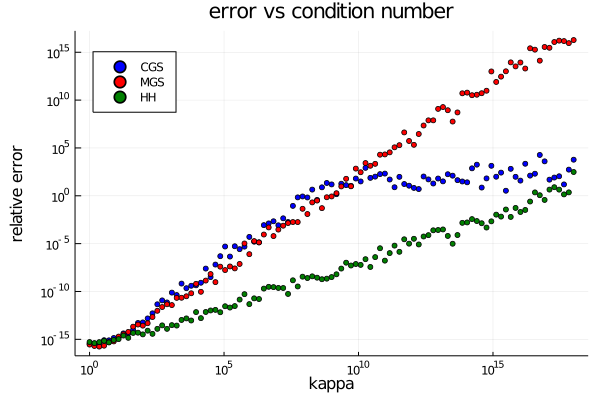

In [10]:
x = data[:,1]
c = data[:,2]
m = data[:,3]
h = data[:,4]

scatter(x,c, color=:blue, label="CGS", markersize=3)
scatter!(x,m, color=:red, label="MGS", markersize=3)
scatter!(x,h, color=:green, label="HH", markersize=3)
plot!(xscale=:log, yscale=:log, xlabel="kappa", ylabel="relative error")
plot!(legend=:topleft, title="error vs condition number")

## Problem 6 
Comment on your results. What can you explain about the scatter plots 
based on the algorithms and their implementation in finite-precision arithmetic?
Or, contrariwise, what can you say about the algorithms based on the scatter 
plots? 

* CGS and MGS have similar error for matrices with $\kappa < 10^8$. For higher condition numbers, CGS is poor, MGS is worse.

* Householder is the best choice at any condition number. Also, we can show that Householder is backward stable, since the slope of the green (HH) line is 1, but CGS and MGS are not.

## Problem 7 (optional)
If you are curious, repeat problem 5 for a different value of $m$ 
(perhaps $m=100$). Does the dimensionality of the matrix (the value of $m$) 
make any difference?

In [13]:
m = 500

pts = 21 #no of points desired in each plot
p = 18 #exponent of largest condition number

data = zeros(pts,4)

for i in 0:pts-1
    kappa = 10^(i*p/(pts-1))
    A = randommatrix(m, kappa)
    x = rand(m)
    b = A*x
    data[i+1,1] = kappa
    
    (Q,R) = qrcgs(A)
    xhat = backsub(R,Q'*b)
    data[i+1,2] = norm(xhat-x)/norm(x)
    
    (Q,R) = qrmgs(A)
    xhat = backsub(R,Q'*b)
    data[i+1,3] = norm(xhat-x)/norm(x)
    
    (Q,R) = qrhouse(A)
    xhat = backsub(R,Q'*b)
    data[i+1,4] = norm(xhat-x)/norm(x)
end

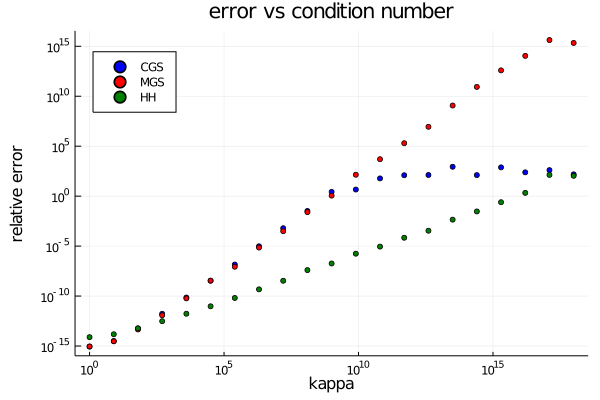

In [14]:
x = data[:,1]
c = data[:,2]
m = data[:,3]
h = data[:,4]

scatter(x,c, color=:blue, label="CGS", markersize=3)
scatter!(x,m, color=:red, label="MGS", markersize=3)
scatter!(x,h, color=:green, label="HH", markersize=3)
plot!(xscale=:log, yscale=:log, xlabel="kappa", ylabel="relative error")
plot!(legend=:topleft, title="error vs condition number")

* The scatter becomes much tighter

* It seems that, for well-conditioned matries, CGS and MGS maybe better than Householder.

## Problem 8 (optional)

You probably wrote your QR and backsolve algorithms assuming that matrix $A$ is square. Revise your functions to work on nonsquare $m \times n$ matrices as well.

## Problem 9 (optional)

The QR decompositon algorithms break down when the matrix $A$ is singular. Revise your CGS, MGS, and Householder QR algorithms to handle singular matrices gracefully. Show revised algorithms work well on singular or nearly singular matrices.

## Problem 10 (optional)

As shown in the lecture demo, the breakdown of CGS and MGS algorithms as $A$ becomes singular is a loss of orthogonality in the matrix $Q$. Can you think of any way to revise CGS or MGS to improve the orthogonality of $Q$, perhaps by rerunning CGS or MGS on the not-quite-orthogonal $Q$ matrix from a first pass of the algorithm? Or by recalculating each $q_j$ from the first-pass approximate $q_j$ in each pass of the ``for j = 1 to m`` loop? Does any such method work? Why or why not?

## Problem 11 (optional)

Julia uses 64-bit floating-point numbers by default. E.g. 

In [1]:
using LinearAlgebra

A = randn(3,3)

3×3 Array{Float64,2}:
 -0.843783   0.986725  -0.803906
  1.8129    -0.825827  -2.74573
 -0.552135   0.965572  -0.836146

However, you can specify 16-bit, 32-bit, and arbitrary-precision floating-point numbers if you want, e.g.

In [2]:
@show Float16(pi)
@show Float32(pi)
@show Float64(pi)
@show BigFloat(pi)
A = BigFloat(1.0)*randn(3,3)

Float16(pi) = Float16(3.14)
Float32(pi) = 3.1415927f0
Float64(pi) = 3.141592653589793
BigFloat(pi) = 3.141592653589793238462643383279502884197169399375105820974944592307816406286198


3×3 Array{BigFloat,2}:
 -0.748496   -1.56956     0.881072
  0.0877648  -0.250928   -0.284481
 -0.0907535   0.0154777  -0.205605

In [3]:
setprecision(1024)  # 1024 bits
BigFloat(pi)

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

For optional problem 10, revise your CGS, MGS, Householder, and backsolve functions to work equally well on matrices of all floating-point number types. To get you started, here's how to revise your function signatures to access and use type information from function arguments.


In [4]:
# Function f takes an m x n matrix as input and returns 
# a zero matrix of same size and numeric type

function f(A::Array{T,2}) where T
    (m,n) = size(A)
    Z = zeros(T, m,n)
end

@show f(ones(Float16,1,1))
@show f(ones(Float32,1,1))
@show f(ones(Float64,1,1))
@show f(ones(BigFloat,1,1))
@show f(ones(Complex{BigFloat},1,1));

f(ones(Float16, 1, 1)) = Float16[0.0]
f(ones(Float32, 1, 1)) = Float32[0.0]
f(ones(Float64, 1, 1)) = [0.0]
f(ones(BigFloat, 1, 1)) = BigFloat[0.0]
f(ones(Complex{BigFloat}, 1, 1)) = Complex{BigFloat}[0.0 + 0.0im]


## Julia syntax tips

In [5]:
# a function that returns two values in a tuple
function f(x)
    2x, x-1
end

s,t = f(4)

(8, 3)

In [6]:
# allocating an 2 x 3 matrix of zeros
A = zeros(2,3)

2×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [7]:
# getting the type of a numerical variable and allocating a matrix of that type
x = BigFloat(pi)
T = typeof(x)
A = zeros(T, 2, 3)

2×3 Array{BigFloat,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [8]:
# In Julia, variables are references (pointers) to objects.
# The assignment below creates a new reference to the same object.
# So a change made to one affects the other.
a1 = [0; 0; 0]
v1 = a1

v1[1] = 999

@show a1
@show v1;


a1 = [999, 0, 0]
v1 = [999, 0, 0]


In [9]:
# If you want an entirely new copy of a vector or matrix, use copy()
a1 = [0; 0; 0]
v1 = copy(a1)

v1[1] = 999;

@show a1
@show v1;


a1 = [0, 0, 0]
v1 = [999, 0, 0]


In [10]:
# Matrix-vector syntax is much like Matlab. But use square brackets!
A = zeros(4,4)
B = ones(4,3)
A[:, 1:3] = B

4×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [11]:
v1 = [1 ; 1 ; 1]
v2 = [2 ; 3 ; 4]

@show dot(v1, v2)
@show v1' * v2

dot(v1, v2) = 9
v1' * v2 = 9


9

In [12]:
# Some thing that work in Matlab need different syntax in Julia,
# due to Julia's stricter typing 
A = rand(4,4)
B = rand(4,4)

# This will through an error in Julia, though it works in Matlab
# A[1,:] * B[:,3]  

# In Julia, use the dot function
dot(A[1,:], B[:,3])

0.3709424637761871

In [13]:
# Julia's dot syntax is more consistent than Matlab's.
# If you want to apply a scalar function to a vector of values,
# you need to use dots

x = range(0.0, pi, length=10)
sin.(x)

10-element Array{Float64,1}:
 0.0
 0.3420201433256687
 0.6427876096865393
 0.8660254037844386
 0.984807753012208
 0.984807753012208
 0.8660254037844387
 0.6427876096865395
 0.3420201433256689
 1.2246467991473532e-16

In [14]:
# This distinction is sometimes meaningful and important!
A = [1 0; 0 2]

# The exponential of a mtrix
exp(A)       

2×2 Array{Float64,2}:
 2.71828  0.0
 0.0      7.38906

In [15]:
# Elementwise exponential 
exp.(A)

2×2 Array{Float64,2}:
 2.71828  1.0
 1.0      7.38906

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


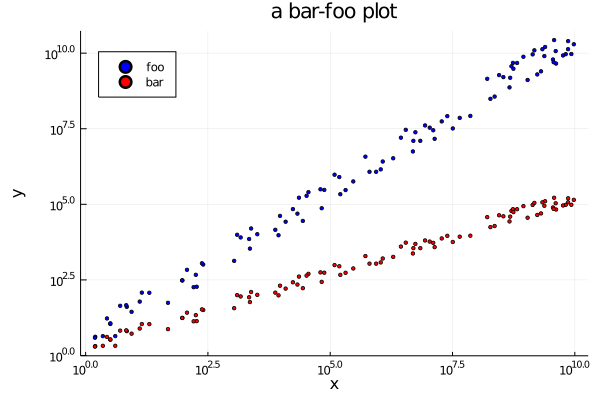

In [50]:
# A scatter plot with axis labels, logarithmic axes, etc. 

using Plots

N = 100
x = 10.0.^(10*rand(N))  # N random numbers between 1 and 10^20
y = x .* 10.0.^rand(N)      # multiply x's by randoms between 1 and 10
z = sqrt.(y)

scatter(x,y, color=:blue, label="foo", markersize=2)
scatter!(x,z, color=:red,  label="bar", markersize=2)
plot!(xscale=:log, yscale=:log, xlabel="x", ylabel="y")
plot!(legend=:topleft, title="a bar-foo plot")